In [1]:
# Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

# classical machine learning
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# for NN
import tensorflow as tf

## 1. Import Data

In [2]:
# item categories
item_categories_df = pd.read_csv('data/item_categories.csv')
# shops
shops_df = pd.read_csv('data/shops.csv')
# items
items_df = pd.read_csv('data/items.csv')
# sales 
sales_train_df = pd.read_csv('data/sales_train.csv')

display(items_df.describe().T)
display(sales_train_df)

,count,mean,std,min,25%,50%,75%,max
item_id,22170.0,11084.500000,6400.072070,0.0,5542.25,11084.5,16626.75,22169.0
item_category_id,22170.0,46.290753,15.941486,0.0,37.00,40.0,58.00,83.0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


## 2. Exploratory Data Analysis

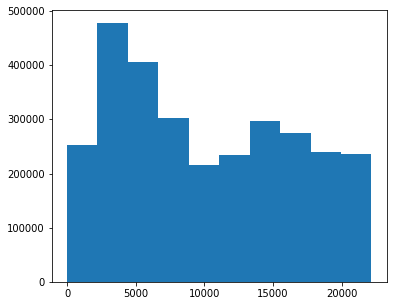

In [3]:
plt.figure(figsize=(6,5))
plt.hist(sales_train_df['item_id'])
plt.show();

In [4]:
print(f"There are {len(sales_train_df['item_id'].unique())} unique items")

There are 21807 unique items


In [5]:
sales_train_df[['shop_id','item_id','item_price','item_cnt_day']].corr()

,shop_id,item_id,item_price,item_cnt_day
shop_id,1.000000,0.029396,-0.024034,-0.005230
item_id,0.029396,1.000000,-0.134104,0.016650
item_price,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,-0.005230,0.016650,0.011197,1.000000


As excepted no significant correlation between any 2 columns.

In [6]:
# EDA on train data
sales_train_df.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64

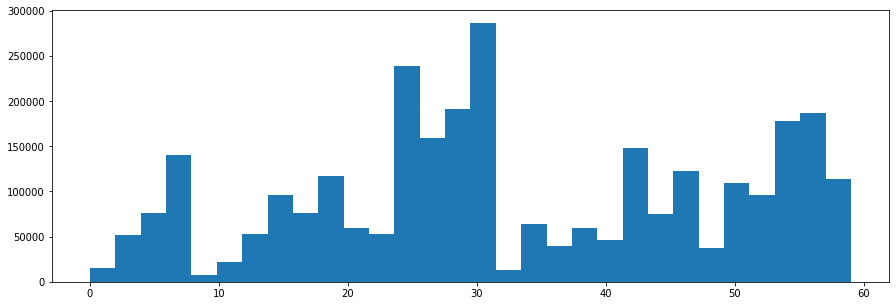

In [7]:
# Distribution of shop_id
plt.figure(figsize=(15,5))
plt.hist(sales_train_df['shop_id'], bins=30)
plt.show();

In [8]:
# Getting total sales of a shop for a unique item and date
# Transforming sales training set to required format as test.csv
sales_train_df_groupby = sales_train_df.groupby(['shop_id','item_id','date_block_num'])['item_cnt_day'].sum().reset_index()
sales_train_df_groupby

,shop_id,item_id,date_block_num,item_cnt_day
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0
...,...,...,...,...
1609119,59,22164,27,2.0
1609120,59,22164,30,1.0
1609121,59,22167,9,1.0
1609122,59,22167,11,2.0


Inputs of Test.csv: shop_id, item_id -> Output of Test.csv: item_cnt.

We'll use "sales_train_df_groupby" for training the model. We shall split this into train and validation set to test the model accuracy. Right now, i'm thinking of using a multi-linear or decision tree based regressor. We shall tets the model RMSE and the aim is to get score as close to 1.00 .

## 3. Build Train Model

## 3.1 Ridge Regression for Sales Prediction

As we have seen, there are no obvious correlation between values so I don't see the point to find relevant values to improve accuracy of Ridge Regression Model.

In [9]:
# shop_id and item_id
X = sales_train_df_groupby.drop(columns=['item_cnt_day','date_block_num'])
# items sold per day
y = sales_train_df_groupby['item_cnt_day']  
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.head(2)

,shop_id,item_id
358394,19,3619
308964,17,3554


In [10]:
# create regression model
linear_regressor = Ridge()
# perform linear regression
linear_regressor.fit(X_train, y_train) 
# make predictions
Y_pred = linear_regressor.predict(X_test)

In [11]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, Y_pred)))

RMSE: 7.530846111644844


RMSE is 7.5 which means that model is having much deviation from the actual sale value. And this is predictable, but for general prectice it is necessary. I'm sure that Catboost model perform better than linear regression.

## 3.2 CatBoost Model

To better perform the task, we need to add a product category. Any additional information can improve accuracy.

In [12]:
# select just categorical data from items_df
df_items = items_df[['item_id','item_category_id']]
# concatenate the column to the table
X_train = sales_train_df_groupby.merge(df_items, how='inner', on='item_id').drop('item_cnt_day', axis=1)
y_train = sales_train_df_groupby[['item_cnt_day']]
display(X_train)
display(y_train)

,shop_id,item_id,date_block_num,item_category_id
0,0,30,1,40
1,1,30,1,40
2,2,30,2,40
3,2,30,5,40
4,2,30,15,40
...,...,...,...,...
1609119,59,9760,12,37
1609120,59,12846,10,37
1609121,59,16270,6,75
1609122,59,17732,9,28


,item_cnt_day
0,31.0
1,11.0
2,6.0
3,10.0
4,3.0
...,...
1609119,2.0
1609120,1.0
1609121,1.0
1609122,2.0


In [13]:
# import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [14]:
from catboost import CatBoostRegressor
xg_reg = CatBoostRegressor()
xg_reg.fit(X_train_cb, y_train_cb)

In [15]:
preds = xg_reg.predict(X_test_cb)

In [16]:
print("RMSE: %f" % (np.sqrt(mean_squared_error(y_test_cb, preds))))

RMSE: 7.849713


Catboost shows better results than linear regression. But these result are not satisfactory, I hope that ExtraTreesRegressor will work better.

## 3.3 Extra Trees Regressor.

In [17]:
# Random forest regressor model building
from sklearn.ensemble import ExtraTreesRegressor
X_train_et, X_test_et, y_train_et, y_test_et = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
ET_model = ExtraTreesRegressor()
ET_model.fit(X_train_et, y_train_et)

/var/folders/yt/s_gzhgxd34794drv5n67w0dw0000gn/T/ipykernel_1197/1899690738.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ET_model.fit(X_train_et, y_train_et)


ExtraTreesRegressor()

In [18]:
ET_pred = ET_model.predict(X_test_et)

In [19]:
print("RMSE: %f" % (np.sqrt(mean_squared_error(y_test_et, ET_pred))))

RMSE: 7.728103


Extra Tress and CatBoost are almost having same error predicting.

## 4. Deep Learning Model

## 4.1 Time Series Analysis

I have to understand exactly that data is suitable for deep learning method. Any DL Model should 'catch on' to some pattern and if a data does not have stationarity then we will not able to train the model. Now we should reject or confirm null hypothesis.

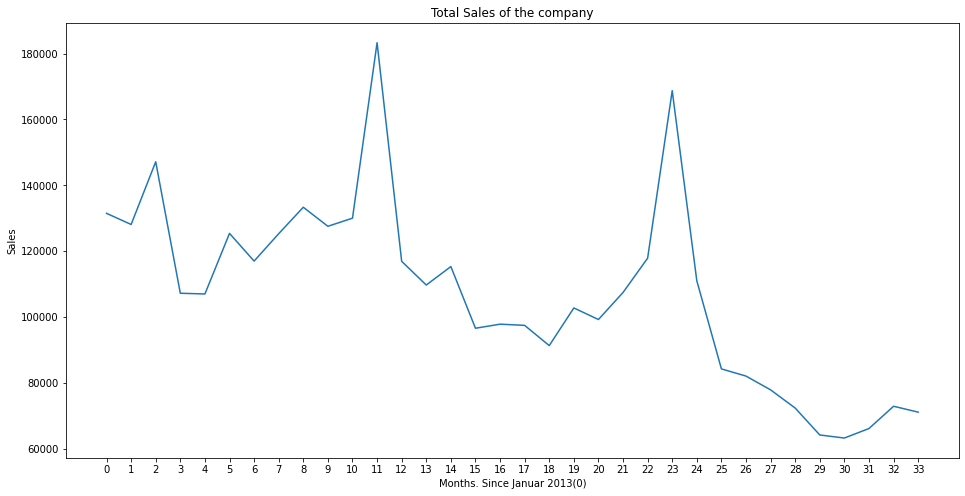

In [20]:
ts = sales_train_df.groupby(["date_block_num"])["item_cnt_day"].sum().astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Months. Since Januar 2013(0)')
plt.xticks(np.arange(0, 34))
plt.ylabel('Sales')
plt.plot(ts);

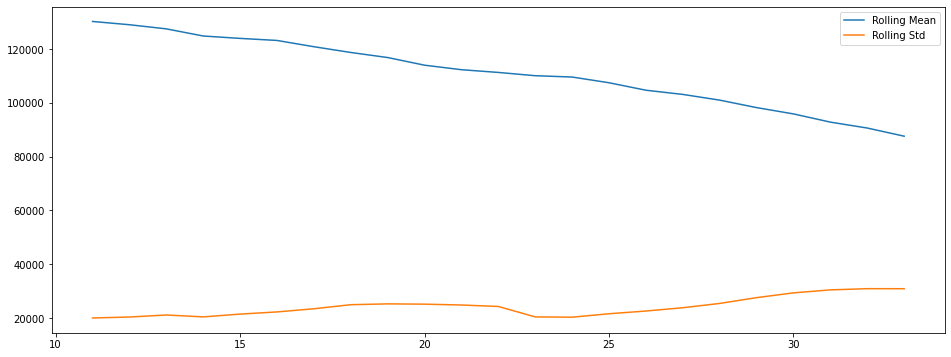

In [21]:
plt.figure(figsize=(16,6))
# calculate mean value for every 12 months
plt.plot(ts.rolling(12, center=False).mean(), label='Rolling Mean');
# calculate standard value for every 12 months
plt.plot(ts.rolling(12, center=False).std(), label='Rolling Std');
# display legend
plt.legend();

Observations: There is an obvious **seasonality** and a **decreasing trend**.

Let's check that with a quick decomposition into trend, seasonality and residuals.

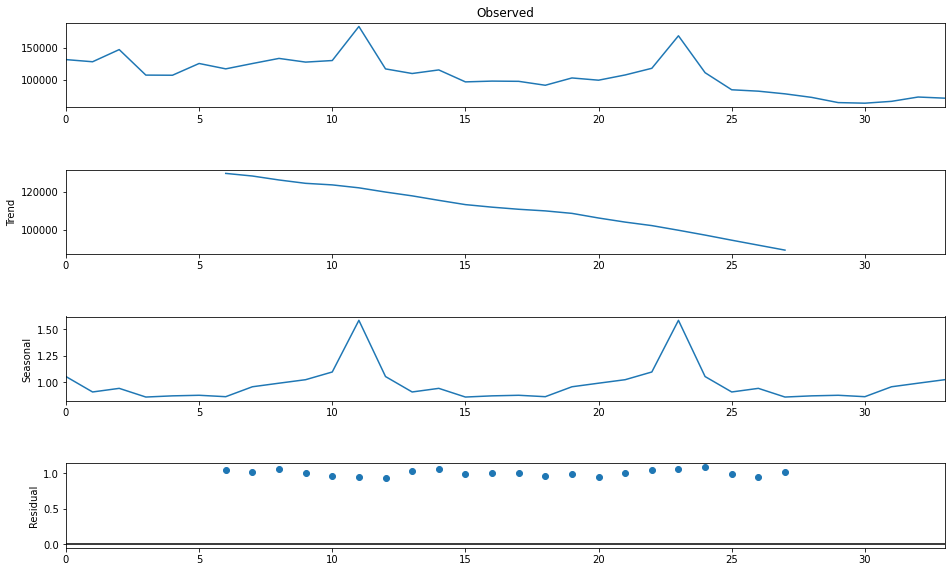

In [22]:
# multiplicative model
res = sm.tsa.seasonal_decompose(ts.values, period=12, model="multiplicative")
fig = res.plot()
fig.set_size_inches(15,9)

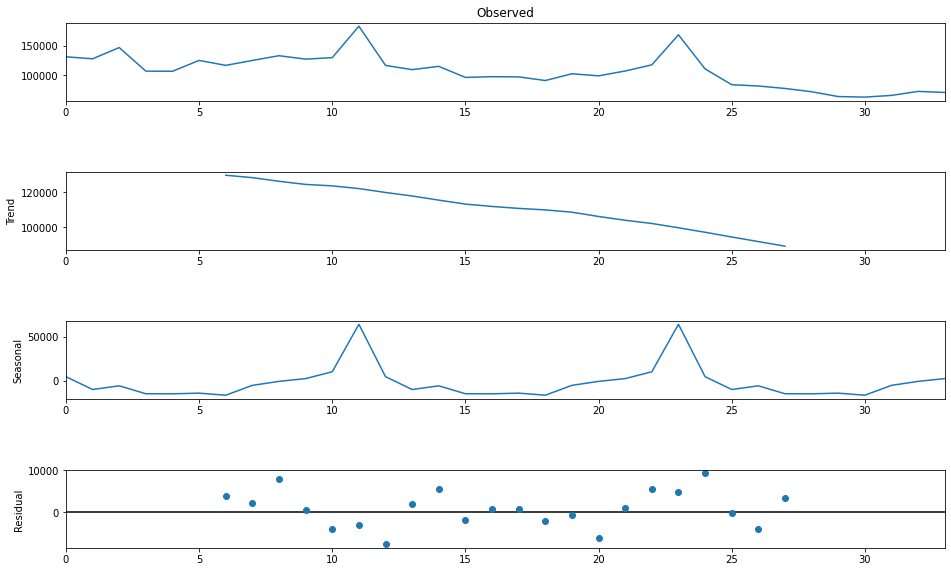

In [23]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values, period=12, model="additive")
fig = res.plot()
fig.set_size_inches(15,9)

It looks like Seasional and Residual plots have a common behavior. Now we shall conduct ADF stationary test to check whether TS in non-stationary.

In [24]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

# Stationarity tests
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

test_stationarity(ts)
kpss_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64
Results of KPSS Test:
Test Statistic           0.628291
p-value                  0.020064
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity. Let's create DL model.

## 3.4 LSTM Model

The most suitable for TS is LSTM model. It can remember last value and thus, it is better to remember what value, for example, was in this month with a certain value and so predict sales in similar situations. Since we only work with sales values, we don't need a category or product name - just month and sales. Let's create rows with unique pairs shop_id + item_id every month in data.

In [25]:
dataset = []
dataset = sales_train_df.pivot_table(index=['shop_id', 'item_id'],
                                     values=['item_cnt_day'],
                                     columns=['date_block_num'],
                                     fill_value=0,
                                     aggfunc='sum')
dataset.reset_index(inplace = True)
dataset.head(2)

shop_id item_id item_cnt_day                        ...        \
date_block_num                            0   1  2  3  4  5  6  7  ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0  ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  

[2 rows x 36 columns]

In [26]:
test_df = pd.read_csv('data/test.csv')
test_df.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


Now we should select products that will be in test dataset.

In [27]:
dataset = pd.merge(test_df, dataset, on=['item_id','shop_id'], how='left')

/var/folders/yt/s_gzhgxd34794drv5n67w0dw0000gn/T/ipykernel_1197/3362284656.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dataset = pd.merge(test_df, dataset, on=['item_id','shop_id'], how='left')
/var/folders/yt/s_gzhgxd34794drv5n67w0dw0000gn/T/ipykernel_1197/3362284656.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dataset = pd.merge(test_df, dataset, on=['item_id','shop_id'], how='left')


In [28]:
# fill NAN's
dataset.fillna(0, inplace = True)
# drop unnecessery columns
dataset.drop(['shop_id', 'item_id', 'ID'], inplace = True, axis = 1)
dataset.shape

(214200, 34)

In [29]:
# X we will keep all columns except the last one 
X_train_dl = np.expand_dims(dataset.values[:,:-1],axis = 2)
# labels
y_train_dl = dataset.values[:,-1:]
# for test we keep all the columns execpt the first one
X_test_dl = np.expand_dims(dataset.values[:,1:],axis = 2)
# lets have a look on the shape 
print(X_train_dl.shape, y_train_dl.shape, X_test_dl.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [30]:
def build_model():
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), input_shape=(33, 1)))

    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer='uniform'))
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer = tf.keras.optimizers.RMSprop(clipvalue=1.0), loss = 'mse', metrics=['mse'])

    model.summary()
    
    return model

In [31]:
model = build_model()

2022-08-03 15:36:08.713531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 33, 256)          133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 33, 128)          164352    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 33, 128)           0         
                                                                 
 flatten (Flatten)           (None, 4224)              0         
                                                                 
 dense (Dense)               (None, 32)                135200    
                                                                 
 dense_1 (Dense)             (None, 1)                 3

In [32]:
save_w = tf.keras.callbacks.ModelCheckpoint("ModelLSTM.h5", monitor='val_loss', verbose=1, save_best_only=True)

model.fit(X_train_dl, 
          y_train_dl, 
          validation_split=0.2, 
          epochs=5, 
          batch_size=512, 
          verbose=1, 
          callbacks=[save_w]);

Epoch 1/2
335/335 [==============================] - ETA: 0s - loss: 35.5711 - mse: 35.5711
Epoch 1: val_loss improved from inf to 0.77252, saving model to ModelLSTM.h5
335/335 [==============================] - 144s 412ms/step - loss: 35.5711 - mse: 35.5711 - val_loss: 0.7725 - val_mse: 0.7725
Epoch 2/2
335/335 [==============================] - ETA: 0s - loss: 32.8313 - mse: 32.8313
Epoch 2: val_loss did not improve from 0.77252
335/335 [==============================] - 142s 423ms/step - loss: 32.8313 - mse: 32.8313 - val_loss: 0.8808 - val_mse: 0.8808


In [33]:
model.evaluate(X_train_dl, y_train_dl)

6694/6694 [==============================] - 99s 15ms/step - loss: 28.3224 - mse: 28.3224


[28.322446823120117, 28.322446823120117]

## 4. Predict

In [34]:
model = tf.keras.models.load_model('ModelLSTM.h5')

In [35]:
# creating submission file 
submission = model.predict(X_test_dl, verbose=1)
# we will keep every value between 0 and 20
submission = submission.clip(0,20)

6694/6694 [==============================] - 91s 13ms/step


In [36]:
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':test_df['ID'],'item_cnt_month':submission.ravel()})
# creating csv file from dataframe
submission.to_csv('submission.csv',index = False)

## Score: 1.02750